In [1]:
# Initialization

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scraper import Product
import nltk

plt.style.use('dark_background')

EU = 'België;Bulgarije;Cyprus;Denemarken;Duitsland;Estland;Finland;Frankrijk;Griekenland;Hongarije;Ierland;Italië;Kroatië;Letland;Litouwen;Luxemburg;Malta;Nederland;Oostenrijk;Polen;Portugal;Roemenië;Slovenië;Slowakije;Spanje;Tsjechië;Zweden'.split(';')

In [11]:
product = Product('B084S4FD5T')

#   962 Reviews - B084TSLMC6
#   110 Reviews - B084S4FD5T

In [12]:
# Title, Price, Overall Average Stars




print(product.title)
print(product.price)
print(product.stars + ' stars')

# product.save_reviews()

Fujifilm instax mini 11 Sky Blue, instant mini camera
€75,00
4,6 stars


In [13]:
# Processed Table

df = pd.read_csv(f'./Reviews/{product.asin}-reviews.csv', index_col=0)
df['rating'] = df['rating'].str.split(',').str[0].astype(np.int8)

df['country'] = df['country'].str.extract(r"([a-z|A-Z|\s|ë|'|-]*)")
df['country'] = df['country'].str.strip()

month_dict = {'januari': 'january', 'februari': 'february', 'maart': 'march', 'mei': 'may', 'juni':'june', 'juli': 'july', 'augustus': 'august', 'oktober': 'october' }

df['date'] = df['date'].replace(month_dict, regex=True)
df['date'] = pd.to_datetime(df['date'])

# alternate way is df['column'].str[:1].astype(np.int8) but str.split() method is optimized for vectorized operations.
# str[:1] method requires slicing each string in the column individually, which can be slower for large datasets.

# df.head(len(df))

# EDA

## Rating Statistics 

Average rating: 4.02
Gemiddelde waardering: 4.02



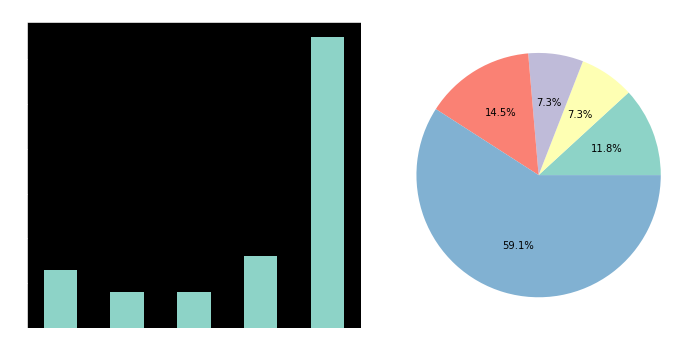

In [14]:
# Average rating, Star Count, Percentage Distribution

ratings_counts = df['rating'].value_counts().sort_index()

#   Count plot of rating

fig, (ax, bx) = plt.subplots(ncols=2, figsize=(10, 5))

ratings_counts.plot(kind='bar', ax=ax)
ax.set_title('Star Count')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0);


# Pie plot of % of rating

wig, labels, pcts = bx.pie((ratings_counts), 
                                labels= ratings_counts.index,
                                autopct='%.1f%%');
bx.set_title('Ratings distribution')
plt.setp(pcts, color='black');
plt.setp(labels, fontweight='bold')


fig.tight_layout()


# Average rating
print(f'Average rating: {df["rating"].mean().round(2)}')
print(f'Gemiddelde waardering: {df["rating"].mean().round(2)}')
# print(f'Median rating: {df["rating"].median().round(2)}')
print('')

## Country Statistics

The country with the most customers is het Verenigd Koninkrijk
Het land met de meeste klanten is het Verenigd Koninkrijk


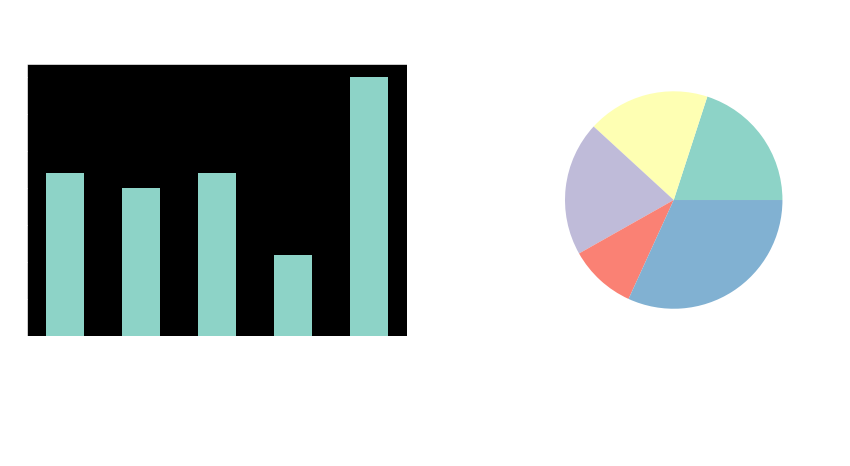

In [15]:
# Country with most customers, Country Customer Count, Percentage Distribution, Avg Rating by country
df_eu = df[df['country'].isin(EU)]
df_noteu = df[~df['country'].isin(EU)]
country_counts = df['country'].value_counts().sort_index()
country_rating = df.groupby('country')['rating'].mean()

print(f'The country with the most customers is {country_counts[country_counts == max(country_counts)].index[0]}')
print(f'Het land met de meeste klanten is {country_counts[country_counts == max(country_counts)].index[0]}')

fig2, (ax, bx) = plt.subplots(ncols=2, figsize=(15, 5))

#   Count plot of countries
country_counts.plot(kind='bar', ax=ax)

ax.set_title('Country Count')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);


# Pie plot of % of countries
labels = [f'{index} {(value/country_counts.sum())*100:.1f}%' for index, value in zip(country_counts.index, country_counts)]

wig, labels = bx.pie((country_counts), 
                        labels=labels, rotatelabels=90);

bx.set_title('Distribution of reviews by country', y=-0.3,);




The country with the worst opinion of the product is: Nederland
Het land met het slechtste oordeel over het product is: Nederland


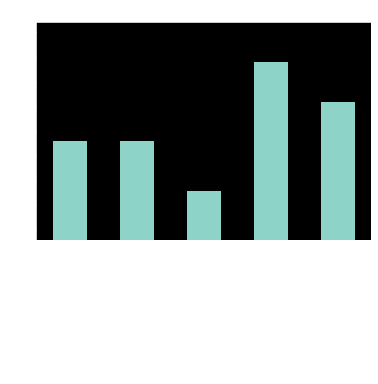

In [16]:
# Rating by country

print(f'The country with the worst opinion of the product is: {country_rating[country_rating == min(country_rating)].index[0]}')
print(f'Het land met het slechtste oordeel over het product is: {country_rating[country_rating == min(country_rating)].index[0]}')

cx = country_rating.round(1).plot(kind='bar', ylim=( (min(country_rating.round(0)) - 0.1) ,5.1));
cx.set_title('Rating by country');

### EU Statistics

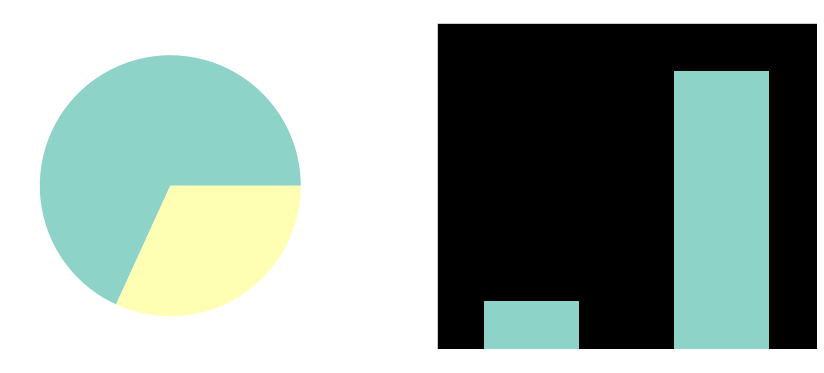

In [17]:
# EU vs Non-EU

fig3, (ax, bx) = plt.subplots(ncols=2, figsize=(15, 6))

wig, labels = ax.pie([len(df_eu), len(df_noteu)], labels=[f'EU {(len(df_eu)/len(df))*100:.2f}%', f'Non-EU {(len(df_noteu)/len(df))*100:.2f}%'])

plt.setp(labels, fontstyle='oblique', fontweight='bold');
ax.set_title('Ratio of EU to Non-EU sales')

if len(df_eu) != len(df):
    pd.Series({'EU': df_eu['rating'].mean(), 'Non-EU': df_noteu['rating'].mean()})\
        .plot(kind='bar', ax=bx, ylim=(abs(min([df_eu['rating'].mean(),  df_noteu['rating'].mean()])-0.1), abs(max([df_eu['rating'].mean(),  df_noteu['rating'].mean()])+0.1)))

    bx.set_xticklabels(bx.get_xticklabels(), rotation=0);
    bx.set_title('EU vs Non-EU average rating');
else:
    pd.Series({'EU': df_eu['rating'].mean()})\
    .plot(kind='bar', ax=bx, ylim=(abs(min(df_eu['rating'].mean())-0.1), 5))

    bx.set_xticklabels(bx.get_xticklabels(), rotation=0);
    bx.set_title('EU vs Non-EU average rating');



# Diachronic analysis

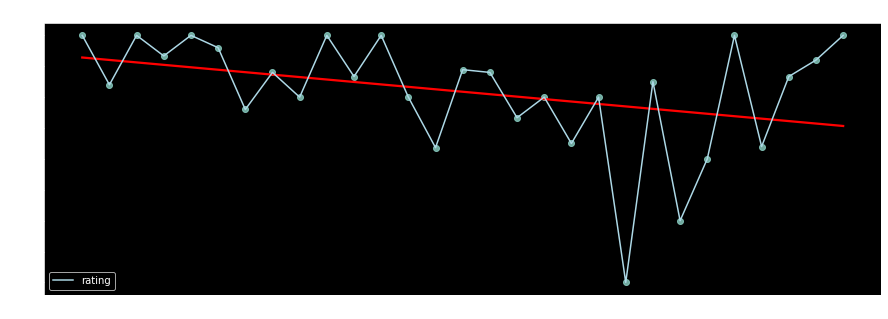

In [18]:
# Rating over time

diachronic_m = df.groupby(df['date'].dt.to_period('M'))['rating'].mean().reset_index()

ax = sns.regplot(x=diachronic_m.index, y=diachronic_m['rating'], ci=None, line_kws={'color': 'red'})
diachronic_m.plot(ax=ax, color='lightblue', figsize=(15, 5));

xticks = diachronic_m.index[::2]
ax.set_xticks(xticks)
ax.set_xticklabels(diachronic_m['date'][::2]);
ax.set_title('Average rating over time');


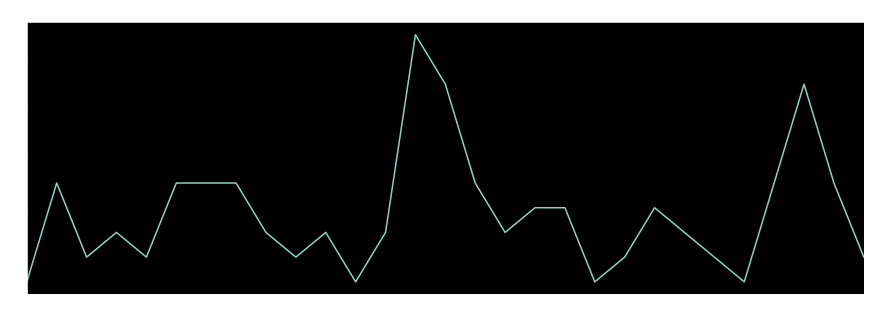

In [19]:
# Number of reviews per month

num = df['date'].dt.to_period('M').value_counts().sort_index()

num.plot( figsize=(15,5), title='Number of reviews per month');